# Importing Libraries

In [1]:
!pip install spektral dask rdp h3 haversine tqdm

In [2]:
!pip install ipycytoscape
!jupyter nbextension enable --py --sys-prefix ipycytoscape
!jupyter nbextension enable --py --sys-prefix widgetsnbextension

Enabling notebook extension jupyter-cytoscape/extension...
      - Validating: OK
Enabling notebook extension jupyter-js-widgets/extension...
      - Validating: OK


In [3]:
!pip install --upgrade dask

In [4]:
!pip install folium shapely psycopg2-binary geopy cvxpy

In [5]:
import pandas as pd
from typing import Dict, Tuple, List
import numpy as np
from tqdm import tqdm
from spektral.utils.convolution import gcn_filter
import dask.dataframe as dd
import dask
import dask.delayed
import dask.array as da
import pickle
import numpy as np
import math

2023-12-26 07:00:30.262945: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2023-12-26 07:00:30.287740: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-12-26 07:00:30.287765: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-12-26 07:00:30.288416: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-12-26 07:00:30.292428: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2023-12-26 07:00:30.292726: I tensorflow/core/platform/cpu_feature_guard.cc:1

In [6]:
import folium
import geopy.distance
import json
from shapely.geometry import LineString, Point
import matplotlib.pyplot as plt
from shapely.ops import shared_paths
import shapely
import pickle as pkl
import cvxpy as cvo
# from pyproj import Geod
from datetime import datetime,timedelta
import h3
# import geopandas
import rdp
import seaborn as sns
from haversine import haversine, Unit
import datetime
import pytz
from itertools import product
import psycopg2

In [7]:
from tensorflow.keras import Model
from tensorflow.keras.layers import LSTM, Dense, Dropout, Input, Reshape
from tensorflow.keras.optimizers import Adam
from spektral.layers import GCNConv
from spektral.utils.convolution import gcn_filter
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

In [8]:
import warnings
warnings.filterwarnings("ignore")

In [9]:
import random
import tensorflow as tf

In [10]:
import dask.dataframe as dd
from dask import delayed

# Utility Functions

In [11]:
def geo_to_segment(latitude,longitude,h3_to_seg,new_segment_dict):
    h3_resolution=11 # edge length approx. 25 meters
    hid=h3.geo_to_h3(latitude,longitude,h3_resolution)
    notfound=True
    k=0
    hex_seg=hid
    while(notfound):
        ring=h3.k_ring(hid,k)
        for nh in ring:
            if nh in list(h3_to_seg.keys()):
                hex_seg=nh
                notfound=False
                break
        k+=1
        if k>3:
            return -1
    segment_ids=h3_to_seg[hex_seg]
    if len(segment_ids)==1:
        if segment_ids[0] in new_segment_dict:
            return segment_ids[0]
        else:
            return
    distances=[]
    for i in range(len(segment_ids)):
        sid=segment_ids[i]
        if sid in new_segment_dict:
            distances.append(min([(((c[0]-longitude)**2)+((c[1]-latitude)**2))**0.5 for c in new_segment_dict[sid]['coordinates']]))
    if len(distances)==0:
        return
    return segment_ids[distances.index(min(distances))]

In [12]:
def Euclidean(p1, p2):
    return (((p1[0]-p2[0])**2)+((p1[1]-p2[1])**2))**0.5

In [13]:
def getH3Dist(p1, p2):
    # this is an approximate multiplication value**
    return h3.h3_distance(geoToH3HighResolution(p1[0], p1[1]), geoToH3HighResolution(p2[0], p2[1]))*0.001348575

In [14]:
def geoToH3HighResolution(latitude, longitude):
    resolution = 14
    return h3.geo_to_h3(latitude, longitude, resolution)

In [15]:
def geoToH3(latitude, longitude):
    resolution = 8
    return h3.geo_to_h3(latitude, longitude, resolution)

In [16]:
def h3ToGeoJson(h3_hash):
    # return '{"type": "FeatureCollection","features": [{"type": "Feature","properties": {},"geometry": {"type": "Polygon","coordinates": ['+str(h3.h3_set_to_multi_polygon([h3_hash], geo_json=True)[0][0])+']}}]}'
    return  '{"type": "Polygon", "coordinates": ['+ str(h3.h3_set_to_multi_polygon([h3_hash], geo_json=True)[0][0]) +'] }'

# Mapping Route ID to Segments

In [17]:
new_segment_dict_full = pd.read_pickle("./new_segment_dict.pkl")  

In [18]:
lengths = []
for seg in new_segment_dict_full:
    lengths.append(new_segment_dict_full[seg]['length'])
print(np.median(lengths))
print(np.mean(lengths))
print(max(lengths))
print(min(lengths))

0.08550824044153141
0.15075762807669035
3.1456344027556646
0.0018155252831053774


In [19]:
max_seg_length = max(lengths)
avg_speed_bus = 10
max_time_eta = max_seg_length*60*60/avg_speed_bus

In [20]:
print(new_segment_dict_full[0].keys())
print(len(new_segment_dict_full))

dict_keys(['segment', 'coordinates', 'length', 'parent_routes'])
5277


In [21]:
segment_dict_full = {val:new_segment_dict_full[val]['segment'] for val in new_segment_dict_full}

In [22]:
def get_segment_dist(coords):
    dist=0
    for index in range(1,len(coords)):
        dist += haversine(coords[index-1], coords[index])
    return dist/2

In [23]:
new_segment_dict = {}
for segid,segment in segment_dict_full.items():
    new_segment_dict[segid]={
        "coordinates":list(segment.exterior.coords),
        "length": get_segment_dist(list(segment.exterior.coords)),
        "polygon": segment
    }

In [24]:
h3_to_seg = pd.read_pickle("./h3_to_seg.pkl") 

In [25]:
route_to_segments = pd.read_pickle("./route_to_segments_new.pkl")

In [26]:
type(route_to_segments), len(route_to_segments["01U"])

(dict, 121)

# Getting Average Dwelltime_df

In [27]:
from dask.distributed import Client, LocalCluster

# Create a local Dask cluster
cluster = LocalCluster(n_workers=4)
client = Client(cluster)
client
# start local workers as threads
# client.processes = False

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:8787/status,
Dashboard: http://127.0.0.1:8787/status,Workers: 4
Total threads: 8,Total memory: 39.70 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:40809,Workers: 4
Dashboard: http://127.0.0.1:8787/status,Total threads: 8
Started: Just now,Total memory: 39.70 GiB
Comm: tcp://127.0.0.1:43909,Total threads: 2
Dashboard: http://127.0.0.1:41307/status,Memory: 9.92 GiB
Nanny: tcp://127.0.0.1:34967,


In [66]:
dwell_df = pd.read_csv("three-months.csv")

In [67]:
len(dwell_df)

7398999

In [68]:
dwell_df.dtypes

Unnamed: 0          int64
observed_time      object
route_id           object
trip_direction     object
segment             int64
segment_dist      float64
time_slot           int64
dwell_speed       float64
dwell_time        float64
license_plate      object
dtype: object

In [69]:
dwell_df = dwell_df[dwell_df['dwell_time'] <= max_time_eta]

In [70]:
len(dwell_df)

3736365

In [71]:
segments = [segid for segid in new_segment_dict.keys()]
time_slots = [time_slot for time_slot in range(8, 20)]

In [72]:
# Rraks
def new_avg_dwelltime_calc(dwell_df):
    grouped_dwell_df = dwell_df.groupby(["segment","time_slot"])["dwell_time"].mean()
    #print(grouped_dwell_df.head())
    #print("---------------------------")
    tdf = grouped_dwell_df.reset_index()
    #print(tdf)
    #print("---------------------------")
    all_combinations = pd.DataFrame(list(product(segments, time_slots)), columns=['segment', 'time_slot'])
    #print(all_combinations)
    #print("---------------------------")
    avg_dwelltime_df = pd.merge(all_combinations, tdf, on=["segment", "time_slot"], how="left")
    #print(avg_dwelltime_df)
    #print("---------------------------")
    avg_dwelltime_df = avg_dwelltime_df.rename(columns={"dwell_time": "avg_dwell_time"})
    
    return avg_dwelltime_df

In [73]:
avg_dwelltime_df = new_avg_dwelltime_calc(dwell_df)

In [74]:
len(segments) * len(time_slots) == len(avg_dwelltime_df)

True

In [75]:
type(avg_dwelltime_df)

pandas.core.frame.DataFrame

In [76]:
len(avg_dwelltime_df)

63324

In [77]:
avg_dwelltime_df.isna().sum()["avg_dwell_time"] / len(avg_dwelltime_df)

0.2510580506600973

In [78]:
def create_neighbours():
    neighbours = {}
    for segid in new_segment_dict_full:
        parent_routes = new_segment_dict_full[segid]["parent_routes"]

        neighbours[segid] = []
        for route_id in parent_routes:
            position = route_to_segments[route_id].index(segid)
            if position - 1 >= 0:
                neighbours[segid].append((route_to_segments[route_id][position - 1], route_id))
            if position + 1 < len(route_to_segments[route_id]):
                neighbours[segid].append((route_to_segments[route_id][position + 1], route_id))
    
    return neighbours

In [79]:
neighbours = create_neighbours()

In [80]:
def get_reasonable_val(avg_dwelltime_df, value, segid, time_slot):
    if not math.isnan(value):
        return value

    vals = []

    for nbr, _ in neighbours[segid]:
        val = avg_dwelltime_df[((avg_dwelltime_df["segment"] == nbr) & (avg_dwelltime_df["time_slot"] == time_slot))]["avg_dwell_time"]
        #print(nbr, time_slot)
        #print(val)
        if not val.isna().bool():
            vals.append(float(val))

    if vals == []:
        if time_slot - 1 >= time_slots[0]:
            val = avg_dwelltime_df[((avg_dwelltime_df["segment"] == segid) & (avg_dwelltime_df["time_slot"] == time_slot - 1))]["avg_dwell_time"]
            #print(val)
            if not val.isna().bool():
                vals.append(float(val))
            for nbr, _ in neighbours[segid]:
                val = avg_dwelltime_df[((avg_dwelltime_df["segment"] == nbr) & (avg_dwelltime_df["time_slot"] == time_slot - 1))]["avg_dwell_time"]
                if not val.isna().bool():
                    vals.append(float(val))

        if time_slot + 1 <= time_slots[-1]:
            val = avg_dwelltime_df[((avg_dwelltime_df["segment"] == segid) & (avg_dwelltime_df["time_slot"] == time_slot + 1))]["avg_dwell_time"]
            if not val.isna().bool():
                vals.append(float(val))
            for nbr, _ in neighbours[segid]:
                val = avg_dwelltime_df[((avg_dwelltime_df["segment"] == nbr) & (avg_dwelltime_df["time_slot"] == time_slot + 1))]["avg_dwell_time"]
                if not val.isna().bool():
                    vals.append(float(val))

    if vals:
        return sum(vals) / len(vals)
  
    return np.nan

In [81]:
global_avg_speed = np.median(dwell_df['dwell_speed']) * 3600 # km/hr

In [82]:
global_avg_speed

17.1662402346894

In [83]:
tqdm.pandas()

In [84]:
def interpolate_df(avg_dwelltime_df):
    # Running this twice to avoid NaNs as much as possible.
    avg_dwelltime_df_copy = avg_dwelltime_df.copy()
    avg_dwelltime_df["avg_dwell_time"] = avg_dwelltime_df.progress_apply(lambda row: get_reasonable_val(avg_dwelltime_df_copy, row["avg_dwell_time"], row["segment"], row["time_slot"]), axis=1)
    avg_dwelltime_df_copy = avg_dwelltime_df.copy()
    avg_dwelltime_df["avg_dwell_time"] = avg_dwelltime_df.progress_apply(lambda row: get_reasonable_val(avg_dwelltime_df_copy, row["avg_dwell_time"], row["segment"], row["time_slot"]), axis=1)
    
    num_zeros_added = avg_dwelltime_df.isna().sum()["avg_dwell_time"]
    global_mean_val = avg_dwelltime_df["avg_dwell_time"].mean()
    mean_added_segs = avg_dwelltime_df[avg_dwelltime_df["avg_dwell_time"].isna()]["segment"].to_list()
    avg_dwelltime_df["avg_dwell_time"] = avg_dwelltime_df["avg_dwell_time"].progress_apply(lambda val: global_mean_val if math.isnan(val) else val)
    
    return avg_dwelltime_df, num_zeros_added, mean_added_segs

In [47]:
avg_dwelltime_df, num_zeros_added_train, mean_added_segs = interpolate_df(avg_dwelltime_df)

100%|██████████| 63324/63324 [00:00<00:00, 2199459.30it/s]


In [48]:
avg_dwelltime_df.to_pickle("interpolated_avg_dwell_time_df_1_hr_slot.pkl")

In [49]:
avg_dwelltime_df.isna().sum()

segment           0
time_slot         0
avg_dwell_time    0
dtype: int64

In [50]:
print(f'{num_zeros_added_train*100/len(avg_dwelltime_df):.2f}% mean value added to training data')

3.82% mean value added to training data


In [51]:
avg_dwelltime_df = pd.read_pickle("interpolated_avg_dwell_time_df_1_hr_slot.pkl")

In [52]:
avg_dwelltime_df

,segment,time_slot,avg_dwell_time
0,0,8,337.193222
1,0,9,333.144456
2,0,10,351.625020
3,0,11,356.954927
4,0,12,421.672686
...,...,...,...
63319,5276,15,4.966140
63320,5276,16,7.616564
63321,5276,17,10.913683
63322,5276,18,11.797847


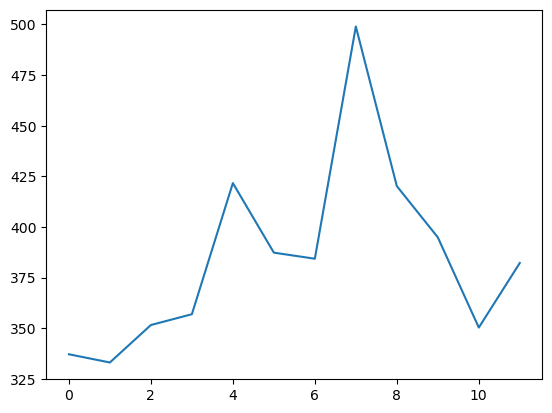

In [53]:
plt.plot(avg_dwelltime_df[avg_dwelltime_df['segment']==0].copy()['avg_dwell_time'].tolist())

# Preprocessing Data

In [85]:
def get_adjacency_matrix(segment_details_dict):
    N = len(segment_details_dict)
    adj_matrix = np.zeros((N, N))

    for segid in tqdm(segment_details_dict.keys()):
      adj_matrix[segid, segid] = 1
      for nbr, _ in neighbours[segid]:
        adj_matrix[segid, nbr] = 1
        adj_matrix[nbr, segid] = 1
    return adj_matrix

In [86]:
def get_group_values(group):
    return group['avg_dwell_time'].tolist() 

In [87]:
def dwell_time_prep(all_surat_segments: List, dwelltime_df: dd.DataFrame, delete_idx: List, num_hours) -> Tuple:
    segments = []
    # Conditional statement to check whether there are any segment IDs to be deleted
    if delete_idx:
        dwelltime_df = dwelltime_df[~dwelltime_df['segment'].isin(delete_idx)]
    dwelltime_df = dwelltime_df[dwelltime_df['segment'].isin(all_surat_segments)]
    data = dwelltime_df.groupby('segment').apply(get_group_values)
    data = data.tolist()
    
    unique_segment_ids = dwelltime_df['segment'].unique()
    segment_ids = unique_segment_ids.tolist()
    for segment in segment_ids:
        if segment in delete_idx:
            continue
        segments.append(segment)
        
    for segment in all_surat_segments:
        if segment not in segments and segment not in delete_idx:
            segments.append(segment)
            data.append([-1 for i in range(32, 96)])
    data = da.from_array(data, chunks=5)
    return data, segments

In [88]:
def preprocess_data(segment_dict: dict, dwelltime_df: dd.DataFrame) -> Tuple:
    """Preprocesses the raw data for ITMS.

    Args:
        segment_dict: Raw data
        dwelltime_df: Raw Data
    Returns: Multiple variables within a Tuple
        dwell_time_data: Dataframe which consists of the preprocessed data
        adj_mat: Square matrix which contains the Adjacency matrix
        segments: List of segments to consider for training the model
        segments_visualize: segments meta-data for dwell time inference plots
    """
    _ = []
    num_hours = 24 * 7

    dwelltime_df['avg_dwell_time'] = dwelltime_df['avg_dwell_time'].astype(float)
    print(dwelltime_df.dtypes)
    print("Dwell time Dataframe preprocessed successfully")
    all_surat_segments = list(segment_dict.keys())
    print("Segments data preprocessed successfully")
    print(f'No. of segments: {len(all_surat_segments)}')
    print(dwelltime_df.head())

    data, segments = dwell_time_prep(all_surat_segments, dwelltime_df, _, num_hours)
    
    adj_mat = get_adjacency_matrix(segment_dict)
    print(f"Shape of data initially : {str(data.shape)}")
    print(f"Shape of Adjacency matrix : {str(adj_mat.shape)}")
    del_idx = []

    data, segments = dwell_time_prep(all_surat_segments, dwelltime_df, del_idx, num_hours)
    print(f"Shape of data after preprocessing : {str(data.shape)}")

    dwell_time_data = dd.from_dask_array(data)

    #dwell_time_data.columns = dwell_time_data.columns.astype(str)

    dwelltime_df = dwelltime_df[~dwelltime_df['segment'].isin(del_idx)]

    segment_count = dwelltime_df[dwelltime_df['avg_dwell_time'] > 0]['segment'].value_counts()
    segment_count = segment_count.to_dict()
    segments_visualize = []
    max_count = max(segment_count.values())
    
    print(dwell_time_data.head())

    return dwell_time_data, adj_mat, segments, segments_visualize


In [58]:
dwell_time_preprocessed_data,adjacency_matrix,preprocessed_segments,segments_visualize = preprocess_data(new_segment_dict, avg_dwelltime_df)

segment             int64
time_slot           int64
avg_dwell_time    float64
dtype: object
Dwell time Dataframe preprocessed successfully
Segments data preprocessed successfully
No. of segments: 5277
   segment  time_slot  avg_dwell_time
0        0          8      337.193222
1        0          9      333.144456
2        0         10      351.625020
3        0         11      356.954927
4        0         12      421.672686


100%|██████████| 5277/5277 [00:00<00:00, 253230.31it/s]


Shape of data initially : (5277, 12)
Shape of Adjacency matrix : (5277, 5277)
Shape of data after preprocessing : (5277, 12)
           0           1           2           3           4           5   \
0  337.193222  333.144456  351.625020  356.954927  421.672686  387.343480   
1  310.729539  284.091649  301.237047  327.563457  375.505237  315.313454   
2   83.544064   83.544064   83.544064   83.544064  134.483667  152.054116   
3  226.495513  238.188450  233.469572  217.081050  219.783305  225.876546   
4  203.303131  194.315396  185.263757  188.323455  191.197583  213.936907   

           6           7           8           9           10          11  
0  384.347226  498.958901  420.180792  394.899070  350.369595  382.250918  
1  333.180189  437.528937  376.698030  324.925273  306.403654  325.917838  
2  152.054116  152.054116  134.483667   83.544064   83.544064   83.544064  
3  226.874595  231.703200  254.231030  278.718477  311.872277  280.863728  
4  215.940989  199.312895  195.5

/opt/conda/lib/python3.11/site-packages/dask/dataframe/_pyarrow_compat.py:23: UserWarning: You are using pyarrow version 13.0.0 which is known to be insecure. See https://www.cve.org/CVERecord?id=CVE-2023-47248 for further details. Please upgrade to pyarrow>=14.0.1 or install pyarrow-hotfix to patch your current version.
  warnings.warn(


In [59]:
np.save(open("preprocessed_segments_1_hr_slot.npy", "wb"), np.array(preprocessed_segments))

In [60]:
dwell_time_preprocessed_data.compute()

/opt/conda/lib/python3.11/site-packages/dask/dataframe/_pyarrow_compat.py:23: UserWarning: You are using pyarrow version 13.0.0 which is known to be insecure. See https://www.cve.org/CVERecord?id=CVE-2023-47248 for further details. Please upgrade to pyarrow>=14.0.1 or install pyarrow-hotfix to patch your current version.
  warnings.warn(
/opt/conda/lib/python3.11/site-packages/dask/dataframe/_pyarrow_compat.py:23: UserWarning: You are using pyarrow version 13.0.0 which is known to be insecure. See https://www.cve.org/CVERecord?id=CVE-2023-47248 for further details. Please upgrade to pyarrow>=14.0.1 or install pyarrow-hotfix to patch your current version.
  warnings.warn(
/opt/conda/lib/python3.11/site-packages/dask/dataframe/_pyarrow_compat.py:23: UserWarning: You are using pyarrow version 13.0.0 which is known to be insecure. See https://www.cve.org/CVERecord?id=CVE-2023-47248 for further details. Please upgrade to pyarrow>=14.0.1 or install pyarrow-hotfix to patch your current versio

,0,1,2,3,4,5,6,7,8,9,10,11
0,337.193222,333.144456,351.625020,356.954927,421.672686,387.343480,384.347226,498.958901,420.180792,394.899070,350.369595,382.250918
1,310.729539,284.091649,301.237047,327.563457,375.505237,315.313454,333.180189,437.528937,376.698030,324.925273,306.403654,325.917838
2,83.544064,83.544064,83.544064,83.544064,134.483667,152.054116,152.054116,152.054116,134.483667,83.544064,83.544064,83.544064
3,226.495513,238.188450,233.469572,217.081050,219.783305,225.876546,226.874595,231.703200,254.231030,278.718477,311.872277,280.863728
4,203.303131,194.315396,185.263757,188.323455,191.197583,213.936907,215.940989,199.312895,195.504648,206.610567,200.528204,228.694525
...,...,...,...,...,...,...,...,...,...,...,...,...
5272,120.973373,216.452694,162.433845,164.266548,151.956611,201.429190,162.972141,161.452670,209.093292,191.344839,95.214081,80.701219
5273,29.222932,80.453657,71.369705,104.692524,198.056704,86.399479,53.234622,200.859031,106.649260,104.863279,131.231565,104.977965
5274,17.629307,96.572357,16.560912,12.348351,45.685536,61.273696,34.636380,15.644490,21.753556,50.656076,41.840388,101.444551
5275,85.473783,896.563392,42.914293,126.627486,56.035202,143.252519,131.378197,25.838364,16.940834,201.285761,603.683610,147.253556


In [61]:
np.save(open("dwell_time_preprocessed_data_1_hr_slot.npy", "wb"), dwell_time_preprocessed_data.compute())

## Finding Correlations

In [66]:
import scipy
dwelltimes = dwell_time_preprocessed_data.compute().to_numpy()
corr_matrix = np.zeros((5277,5277))
for i in tqdm(range(5277)):
    for j in range(5277):
        corr_matrix[i][j] = scipy.spatial.distance.correlation(dwelltimes[i], dwelltimes[j])
        if math.isnan(corr_matrix[i][j]):
            corr_matrix[i][j] = 0

100%|██████████| 5277/5277 [13:37<00:00,  6.45it/s]


In [69]:
temp = corr_matrix.copy()

In [71]:
for i in tqdm(range(5277)):
    for j in range(5277):
        if temp[i][j]<=1:
            temp[i][j] = 1 - temp[i][j]
        elif temp[i][j]>1:
            temp[i][j] = -(temp[i][j]-1)

100%|██████████| 5277/5277 [00:19<00:00, 273.68it/s]


In [75]:
def remove_below_threshold(matrix, threshold):
    filtered_matrix = np.where(matrix < threshold, 0, matrix)
    return filtered_matrix

In [76]:
threshold = 0.65
temp = remove_below_threshold(temp, threshold)

In [78]:
old_adjacency = adjacency_matrix.copy()

In [79]:
adjacency_matrix = np.zeros((len(old_adjacency),len(old_adjacency)))

In [ ]:
'''
# Older Corr Matrix - used in paper
corr_matrix = np.corrcoef(dwell_time_preprocessed_data.compute())
corr_threshold = 0.65
for i in tqdm(range(len(corr_matrix))):
    for j in range(len(corr_matrix)):
        if corr_matrix[i][j]<corr_threshold or math.isnan(corr_matrix[i][j]) or j in set(mean_added_segs) or i in set(mean_added_segs):
            corr_matrix[i][j] = 0 
'''

In [80]:
alpha = 0.85
for segid_i in tqdm(range(len(old_adjacency))):
    for segid_j in range(len(old_adjacency)):
        adjacency_matrix[segid_i][segid_j] = alpha * old_adjacency[segid_i][segid_j] + (1-alpha)*temp[segid_i][segid_j]

100%|██████████| 5277/5277 [00:20<00:00, 258.92it/s]


In [91]:
adjacency_matrix

array([[1.        , 0.04479623, 0.29431905, ..., 1.22993318, 1.50357712,
        1.21947651],
       [0.04479623, 1.        , 0.34783844, ..., 1.38709913, 1.54684353,
        1.30520055],
       [0.29431905, 0.34783844, 1.        , ..., 1.19828788, 1.41372426,
        1.41579776],
       ...,
       [1.22993318, 1.38709913, 1.19828788, ..., 1.        , 0.43279756,
        0.42500562],
       [1.50357712, 1.54684353, 1.41372426, ..., 0.43279756, 1.        ,
        1.00749966],
       [1.21947651, 1.30520055, 1.41579776, ..., 0.42500562, 1.00749966,
        1.        ]])

In [82]:
A_hat = adjacency_matrix
D_hat = np.array(np.sum(A_hat, axis=0))
D_hat = np.matrix(np.diag(D_hat))
print(min(np.diag(D_hat)) , max(np.diag(D_hat)), np.median(np.diag(D_hat)))
neg_idx = [list(np.diag(D_hat)).index(i) for i in np.diag(D_hat) if i<0]
print(len(neg_idx))

2.9182651036099836 84.83042173632028 19.127023845822798
0


In [83]:
np.save(open("adjacency_matrix_1_hr_slot.npy", "wb"), np.array(adjacency_matrix))

In [30]:
adjacency_matrix = np.load(open("adjacency_matrix_1_hr_slot.npy", "rb"))

# Process Test Data

In [46]:
dwelltime_df_test = pd.read_csv("./dwelltime_df_jan_2023_1_hr.csv")

In [47]:
dwelltime_df_test = dwelltime_df_test[dwelltime_df_test['dwell_time']<=max_time_eta]

In [58]:
avg_dwelltime_df_test = new_avg_dwelltime_calc(dwelltime_df_test)

In [59]:
avg_dwelltime_df_test["time_slot"].unique()

array([ 8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19])

In [60]:
avg_dwelltime_df_test

,segment,time_slot,avg_dwell_time
0,0,8,342.581322
1,0,9,333.650861
2,0,10,364.775301
3,0,11,351.399469
4,0,12,357.240116
...,...,...,...
63319,5276,15,NaN
63320,5276,16,NaN
63321,5276,17,NaN
63322,5276,18,NaN


In [61]:
avg_dwelltime_df_test.isna().sum()

segment               0
time_slot             0
avg_dwell_time    22253
dtype: int64

In [62]:
avg_dwelltime_df_test.isna().sum()["avg_dwell_time"] / len(avg_dwelltime_df_test)

0.3514149453603689

In [89]:
avg_dwelltime_df_test, num_zeros_added_test, mean_segs_test = interpolate_df(avg_dwelltime_df_test)

100%|██████████| 63324/63324 [00:00<00:00, 2259676.42it/s]


In [92]:
avg_dwelltime_df_test.to_pickle("testing/interpolated_avg_dwelltime_df_test_1_hr_slot.pkl")

In [93]:
avg_dwelltime_df_test = pd.read_pickle("testing/interpolated_avg_dwelltime_df_test_1_hr_slot.pkl")

In [90]:
avg_dwelltime_df_test.isna().sum()

segment           0
time_slot         0
avg_dwell_time    0
dtype: int64

In [91]:
print(f'{num_zeros_added_test*100/len(avg_dwelltime_df_test):.2f}% mean value added to test data')

6.28% mean value added to test data


In [92]:
columns = [i for i in range(12)]
dwell_time_data_test = pd.DataFrame(columns=columns)

In [93]:
dwell_time_data_test.dtypes

0     object
1     object
2     object
3     object
4     object
5     object
6     object
7     object
8     object
9     object
10    object
11    object
dtype: object

In [94]:
avg_dwelltime_df_test

,segment,time_slot,avg_dwell_time
0,0,8,342.581322
1,0,9,333.650861
2,0,10,364.775301
3,0,11,351.399469
4,0,12,357.240116
...,...,...,...
63319,5276,15,7.780947
63320,5276,16,8.924231
63321,5276,17,10.067516
63322,5276,18,72.921865


In [95]:
for seg in tqdm(range(5277)):
    seg_df = avg_dwelltime_df_test[avg_dwelltime_df_test['segment']==seg].sort_values('time_slot')
    dwell_time_data_test.loc[len(dwell_time_data_test)] = seg_df['avg_dwell_time'].tolist()

100%|██████████| 5277/5277 [00:03<00:00, 1425.62it/s]


In [96]:
dwell_time_data_test = dwell_time_data_test.apply(pd.to_numeric, errors='coerce')

In [97]:
dwell_time_data_test

,0,1,2,3,4,5,6,7,8,9,10,11
0,342.581322,333.650861,364.775301,351.399469,357.240116,354.465542,361.007830,361.702030,413.960253,353.421801,357.467672,387.451783
1,298.403881,329.429831,329.508982,299.113382,324.101466,299.920367,303.946861,312.573388,348.736926,325.457871,294.945819,322.804348
2,82.350617,82.350617,82.350617,82.350617,82.350617,82.350617,82.350617,82.350617,82.350617,82.350617,82.350617,82.350617
3,221.717937,236.034439,229.146370,230.401788,215.167651,224.710223,235.915406,228.561687,260.560556,264.695092,276.885143,263.741448
4,183.269041,182.457024,181.963500,171.343992,175.701194,215.007475,174.127745,189.687850,179.465579,183.841304,179.283420,207.128411
...,...,...,...,...,...,...,...,...,...,...,...,...
5272,450.204044,49.810411,72.576550,122.829442,268.917907,286.004706,118.099783,111.885347,168.274088,141.590711,64.930519,70.851493
5273,29.491371,52.552071,135.560660,84.293353,134.260998,45.029016,96.840993,48.697162,143.971795,101.068355,206.762345,86.532224
5274,140.883911,12.671238,20.318232,13.009125,23.048592,115.643404,56.491049,18.424517,11.424233,18.638867,22.903267,93.310293
5275,126.170112,139.008555,113.123946,242.822735,108.020390,164.496576,112.769600,111.412222,16.940834,110.045846,473.299946,111.004913


# Preparing Data

In [70]:
avg_dwelltime_df = pd.read_pickle("interpolated_avg_dwell_time_df_1_hr_slot.pkl")

In [71]:
adjacency_matrix = np.load(open("adjacency_matrix_1_hr_slot.npy", "rb"))

In [72]:
dwell_time_preprocessed_data = np.load(open("dwell_time_preprocessed_data_1_hr_slot.npy", "rb"))

In [35]:
def scale_data(data):
    max_speed = max_time_eta
    min_speed = 0
    data_scaled = (data - min_speed) / (max_speed - min_speed)
    return data_scaled

In [36]:
def unscale_data(data_scaled):
    max_speed = max_time_eta
    min_speed = 0
    data_unscaled = (data_scaled * (max_speed - min_speed)) + min_speed
    return data_unscaled

In [37]:
def sequence_data_preparation1(seq_len, pre_len, data):
    X, Y = [], []
    data = np.array(data)

    for i in range(data.shape[1] - int(seq_len + pre_len - 1)):
        a = data[:,i: i + seq_len + pre_len]
        X.append(a[:,:seq_len])
        Y.append(a[:,-1])

        
    X = da.from_array(X, chunks=1)#len(trainX)//5)
    Y = da.from_array(Y, chunks=1)#len(trainY)//5)
    
    return X, Y

In [38]:
def clean_prediction(prediction):
    for i in range(prediction.shape[0]):
        for j in range(prediction.shape[1]):
            if prediction[i, j] < 0:
                prediction[i, j] = 0
    return prediction

In [39]:
def augment_data(data, seq_len):
    last_cols = np.array(data)[:, -seq_len:]
    augmented_data = np.append(last_cols, data, axis=1)
    print(augmented_data.shape)
    return augmented_data

In [40]:
def train_test_split_data(dwell_speed_data, parameters: Dict, append_data=True) -> Tuple:
    """Split the data into train and test.

        Args:
            dwell_time_data: Dataframe which consists of the preprocessed data
            parameters: Imports parameters present in ~/conf/base/parameters/data_science.yml
        Returns: Multiple variables within a Tuple
            trainX : Training data
            trainY : Training data
            testX : Test data
            testY : Test data
            test_ex_per_hour : Number of rows in the test data
    """
    seq_len = parameters["seq_len"]
    pre_len = parameters["pre_len"]
    dwell_speed_data = np.array(dwell_speed_data)
    if append_data:
        dwell_speed_data = augment_data(dwell_speed_data, seq_len)

    print(f"Data: {str(dwell_speed_data.shape)}")

    dwell_speed_data_scaled = scale_data(dwell_speed_data)

    X,Y = sequence_data_preparation1(seq_len, pre_len, dwell_speed_data_scaled)

    print(f"X data shape : {str(X.shape)}")
    print(f"Y data shape : {str(Y.shape)}")

    test_ex_per_hour = Y.shape[0]

    return X, Y, test_ex_per_hour

In [41]:
parameters = {'train_test_split_options':{'train_rate': 0.75,'seq_len': 4,'pre_len': 1}, 
              'model_options':{'adam_learning_rate': 0.001,'loss': 'mse','epochs': 35,'batch_size': 32}}

In [109]:
X_train, y_train, test_ex_per_hour = train_test_split_data(dwell_time_preprocessed_data, parameters['train_test_split_options'])

(5277, 16)
Data: (5277, 16)
X data shape : (12, 5277, 4)
Y data shape : (12, 5277)


In [110]:
unscale_data(y_train[:,120].compute())

array([59.97986662, 59.48657425, 59.2390721 , 74.18536778, 58.99359755,
       77.48508682, 61.02277568, 60.92507613, 59.12214646, 78.56643179,
       64.59158943, 75.05612186])

In [98]:
X_test, y_test, _ = train_test_split_data(dwell_time_data_test, parameters['train_test_split_options'])

(5277, 16)
Data: (5277, 16)
X data shape : (12, 5277, 4)
Y data shape : (12, 5277)


In [112]:
unscale_data(y_test[:,120].compute())

array([60.36879694, 56.82540199, 65.16377768, 55.95968391, 53.40506377,
       66.81967866, 55.15650141, 60.408525  , 57.84277966, 56.42203809,
       63.04972739, 60.08787583])

In [113]:
y_train_computed = y_train.compute()
y_train_computed

array([[0.29776119, 0.27439222, 0.07377426, ..., 0.0155677 , 0.07547831,
        0.00839823],
       [0.29418589, 0.25086942, 0.07377426, ..., 0.085279  , 0.79171752,
        0.00688017],
       [0.3105053 , 0.2660098 , 0.07377426, ..., 0.01462425, 0.03789581,
        0.01238717],
       ...,
       [0.3487188 , 0.28692788, 0.07377426, ..., 0.04473226, 0.17774701,
        0.00963742],
       [0.30939669, 0.27057221, 0.07377426, ..., 0.03694749, 0.53308767,
        0.01041818],
       [0.33754975, 0.28780437, 0.07377426, ..., 0.08958143, 0.13003344,
        0.0280995 ]])

In [114]:
np.save(open("y_train_1_hr_slot.npy", "wb"), y_train_computed)

In [115]:
X_train_computed = X_train.compute()
X_train_computed

array([[[0.37104403, 0.3487188 , 0.30939669, 0.33754975],
        [0.33264623, 0.28692788, 0.27057221, 0.28780437],
        [0.11875688, 0.07377426, 0.07377426, 0.07377426],
        ...,
        [0.01920965, 0.04473226, 0.03694749, 0.08958143],
        [0.01495974, 0.17774701, 0.53308767, 0.13003344],
        [0.00672587, 0.00963742, 0.01041818, 0.0280995 ]],

       [[0.3487188 , 0.30939669, 0.33754975, 0.29776119],
        [0.28692788, 0.27057221, 0.28780437, 0.27439222],
        [0.07377426, 0.07377426, 0.07377426, 0.07377426],
        ...,
        [0.04473226, 0.03694749, 0.08958143, 0.0155677 ],
        [0.17774701, 0.53308767, 0.13003344, 0.07547831],
        [0.00963742, 0.01041818, 0.0280995 , 0.00839823]],

       [[0.30939669, 0.33754975, 0.29776119, 0.29418589],
        [0.27057221, 0.28780437, 0.27439222, 0.25086942],
        [0.07377426, 0.07377426, 0.07377426, 0.07377426],
        ...,
        [0.03694749, 0.08958143, 0.0155677 , 0.085279  ],
        [0.53308767, 0.130033

In [119]:
np.save(open("X_train_1_hr_slot.npy", "wb"), X_train_computed)

# Training Model

In [28]:
X_train = np.load(open("X_train_1_hr_slot.npy", "rb"))
#X_train

In [29]:
y_train = np.load(open("y_train_1_hr_slot.npy", "rb"))
#y_train

In [30]:
adjacency_matrix = np.load(open("adjacency_matrix_1_hr_slot.npy", "rb"))
#adjacency_matrix

In [31]:
preprocessed_segments = np.load(open("preprocessed_segments_1_hr_slot.npy", "rb"))
preprocessed_segments

array([   0,    1,    2, ..., 5274, 5275, 5276])

In [148]:
parameters = {'train_test_split_options':{'train_rate': 0.75,'seq_len': 4,'pre_len': 1}, 
              'model_options':{'adam_learning_rate': 0.001,'loss': 'mse','epochs': 35,'batch_size': 32}}

In [134]:
def train_tgcn_model(trainX, trainY, testX, testY, adj_lap, segments, parameters: Dict) -> Tuple:
    """Train the model.

        Args:
            trainX : Training data
            trainY : Training data
            testX : Test data
            testY : Test data
            adj_lap: Square matrix which contains the Adjacency matrix
            segments: List of segments to consider for training the model
            parameters: Dict
        Returns: Multiple variables within a Tuple
            model : Trained model (Pickle format)
            y_true : True Y data from the original test set
            y_pred : Predicted Y data using the original test set
            fig : Plotly JSON data to be showcased on the kedro viz frontend
    """
    print("Using gcn_filter ================")
    adj_lap = gcn_filter(adj_lap, symmetric=False)
    adj_lap = gcn_filter(adj_lap, symmetric=False)
    print(f"Shape of Adjacency Matrix : {str(adj_lap.shape)}")
    N = len(segments)
    print(f"Number of segments : {str(N)}")
    inp_feat = Input((N, trainX.shape[-1]))
    train_losses = []

    #x = GCNConv(32, activation='relu')([inp_feat, adj_lap])
    #print(x.shape)
    x = GCNConv(16, activation='relu')([inp_feat, adj_lap])
    #x = GCNConv(16, activation='relu')([x, adj_lap])
    print(x.shape)
    x = Reshape((16, N))(x)
    print(x.shape)
    #x = LSTM(32, activation='relu', return_sequences=True)(x)
    #x = LSTM(128, activation='relu', return_sequences=True)(x)
    print(x.shape)
    x = LSTM(32, activation='relu')(x)
    #print(x.shape)

    x = Dense(128, activation='relu')(x)
    print(x.shape)
    x = Dropout(0.3)(x)
    out = Dense(N)(x)

    model = Model(inp_feat, out)
    opt = Adam(learning_rate=parameters["adam_learning_rate"])
    model.compile(optimizer=opt, loss=parameters["loss"],
                  metrics=[tf.keras.metrics.RootMeanSquaredError()])
    model.summary()

    callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                patience=5,
                                                restore_best_weights=True)

    print("Model fitting initiated")

    history = model.fit(
        trainX,
        trainY,
        epochs=parameters["epochs"],
        batch_size=parameters["batch_size"],
        shuffle=True,
        verbose=1,
        validation_data=(testX, testY),
        callbacks=[callback]
    )
    
    for epoch, loss in zip(range(parameters["epochs"]), history.history['root_mean_squared_error']):
        print(f"Epoch {epoch + 1}/{parameters['epochs']} - Train Loss: {loss:.4f}")
        train_losses.append(loss)
    

    print("Model trained successfully")

    print("Scaling y_true and y_pred")
    y_true = unscale_data(testY)
    y_pred = clean_prediction(unscale_data(model.predict(testX)))
    print("Scaled y_true and y_pred")

    # Appending the metric meta-data into lists
    epoch = []
    metric_name = []
    metric_val = []
    for k, v in history.history.items():
        for i in range(parameters["epochs"]):
            epoch.append(i + 1)
            metric_name.append(k)
            metric_val.append(v[i])

    # Creating a dataframe using those lists created above
    epoch_metric_plot = pd.DataFrame(dict(
        epoch=epoch,
        metric_name=metric_name,
        metric_val=metric_val
    ))

    # Creating a plotly object to be shown on the kedro viz frontend
    # fig = px.line(epoch_metric_plot, x="epoch", y="metric_val", color="metric_name")

    # Alternate type to store model: tensorflow.TensorFlowModelDataset with .h5 format instead of pickle with .pkl
    return model, y_true, y_pred, epoch_metric_plot, train_losses

In [135]:
tgcn_model, preprocessed_y_true, preprocessed_y_pred, epoch_metric_plot, tgcn_train_losses = train_tgcn_model(X_train, y_train, X_train, y_train, adjacency_matrix, preprocessed_segments, parameters['model_options'])

Using gcn_filter ================
Shape of Adjacency Matrix : (5277, 5277)
Number of segments : 5277
(None, 5277, 16)
(None, 16, 5277)
(None, 16, 5277)
(None, 128)
Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 5277, 4)]         0         
                                                                 
 gcn_conv_2 (GCNConv)        (None, 5277, 16)          80        
                                                                 
 reshape_2 (Reshape)         (None, 16, 5277)          0         
                                                                 
 lstm_2 (LSTM)               (None, 32)                679680    
                                                                 
 dense_4 (Dense)             (None, 128)               4224      
                                                                 
 dropout_2 (Dropout)       

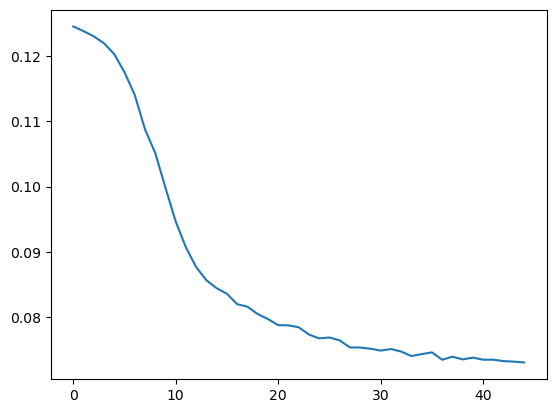

In [136]:
plt.plot(tgcn_train_losses)

# Testing

## On Test Data

In [137]:
y_test_pred = clean_prediction(unscale_data(tgcn_model.predict(X_test.compute()))).T
y_test_true = unscale_data(y_test.compute()).T

1/1 [==============================] - 0s 63ms/step


2023-12-26 07:19:24,090 - distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)
2023-12-26 07:19:25,474 - distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)
2023-12-26 07:19:26,796 - distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)
2023-12-26 07:19:59,266 - distributed.utils_perf - WARNING - full garbage collections took 12% CPU time recently (threshold: 10%)
2023-12-26 07:20:02,274 - distributed.utils_perf - WARNING - full garbage collections took 12% CPU time recently (threshold: 10%)
2023-12-26 07:20:04,682 - distributed.utils_perf - WARNING - full garbage collections took 13% CPU time recently (threshold: 10%)


In [138]:
np.save(open("y_test_pred_1_hr_slot.npy", "wb"), y_test_pred)
np.save(open("y_test_true_1_hr_slot.npy", "wb"), y_test_true)

In [ ]:
y_test_pred = np.load(open("y_test_pred_1_hr_slot.npy", "rb"))
y_test_true = np.load(open("y_test_true_1_hr_slot.npy", "rb"))

In [100]:
from collections import defaultdict

In [139]:
y_test_pred = clean_prediction(y_test_pred)

In [102]:
replace_x_vals = [i+6 for i in range(0,64*20,64)]

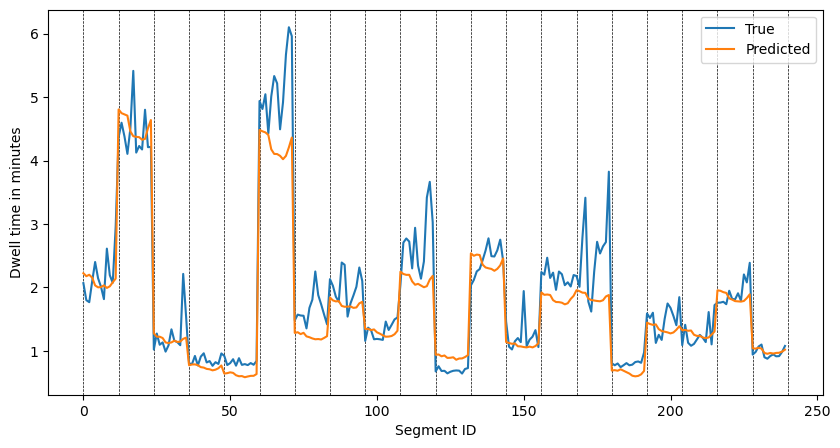

In [140]:
# Plotting for random indices
random_segments_indices = [15, 7, 1084, 4526, 2312, 785]
x_vals = [0]
for j in [100]:#range(0,5277,20):
    y_true_vis = []
    y_pred_vis = []
    for random_segment_index in range(j, j+20):

        #for i in range(preprocessed_y_true.shape[0]):
        for i in range(12):
            y_true_vis.append(y_test_true[random_segment_index][i]/60)
            y_pred_vis.append(y_test_pred[random_segment_index][i]/60)
        x_vals.append(len(y_pred_vis))
    
    plt.figure(figsize=(10, 5))
    for val in x_vals:
        plt.axvline(x=val, linestyle='--', color='black', lw=0.5)
    plt.plot(y_true_vis, label="True")
    plt.plot(y_pred_vis, label="Predicted")
    plt.xlabel("Segment ID")
    plt.legend()
    plt.ylabel("Dwell time in minutes")
    plt.show()

In [141]:
def evaluate_model(y_true, y_pred):
    """Model evaluation and Model inference.

        Args:
            y_true : True Y data from the original test set
            y_pred : Predicted Y data using the original test set
            test_ex_per_hour : Number of rows in the test data
            segments_visualize : segments meta-data for dwell time inference plots
            segments: List of segments to consider for training the model
        Returns: Multiple variables within a Tuple
            metric_output : JSON data to log metrics into the experiments
            hex_evaluation_plot : List of matplotlib plots to be showcased in the kedro experiments
    """
    print(f'MSE : {mean_squared_error(y_true, y_pred)}')
    print(f'RMSE : {math.sqrt(mean_squared_error(y_true, y_pred))}')
    print(f'R-squared : {r2_score(y_true, y_pred)}')
    print(f'MAE : {mean_absolute_error(y_true, y_pred)}')

    # Log metric output in a dictionary to show it on the kedro viz frontend
    # Reference - https://kedro.readthedocs.io/en/stable/visualisation/experiment_tracking.html#set-up-your-nodes-and-pipelines-to-log-metrics
    metric_output = {"MSE": mean_squared_error(y_true, y_pred),
                     "RMSE": math.sqrt(mean_squared_error(y_true, y_pred)),
                     "R-squared": r2_score(y_true, y_pred),
                     "MAE": mean_absolute_error(y_true, y_pred)}
    return metric_output

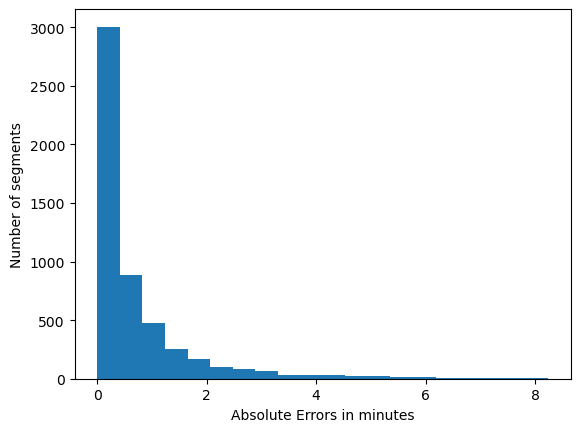

In [142]:
for t_slot in [7]:#tqdm(range(12)):
    error_list = [abs(y_test_true[i][t_slot]-y_test_pred[i][t_slot])/60 for i in range(5277) if abs(y_test_true[i][t_slot]-y_test_pred[i][t_slot])<500]
    plt.hist(error_list, bins=20)
    plt.xlabel("Absolute Errors in minutes")
    plt.ylabel("Number of segments")
    plt.show()

In [143]:
metric_dict = defaultdict(list)
for time_slot in tqdm([i for i in range(12)]):
    metrics = evaluate_model(y_test_true[:,time_slot], y_test_pred[:,time_slot])
    metric_dict['RMSE'].append(metrics['RMSE'])
    metric_dict['MAE'].append(metrics['MAE'])

100%|██████████| 12/12 [00:00<00:00, 526.36it/s]

MSE : 10379.33586196152
RMSE : 101.87902562334172
R-squared : 0.1544038131454719
MAE : 50.21582947559088
MSE : 9495.562187408797
RMSE : 97.44517529056426
R-squared : 0.23228564188935574
MAE : 48.33365358115987
MSE : 9959.03399305362
RMSE : 99.79495975776341
R-squared : 0.24702513811329607
MAE : 49.13320769141267
MSE : 8809.64619903811
RMSE : 93.85971552821854
R-squared : 0.2133571025226787
MAE : 46.35631709471285
MSE : 9332.406115922982
RMSE : 96.60437938273286
R-squared : 0.27541547162985014
MAE : 46.629656742942174
MSE : 8224.919824624547
RMSE : 90.69134371385478
R-squared : 0.2513545296603127
MAE : 45.95303627310397
MSE : 9293.999730505802
RMSE : 96.40539264224695
R-squared : 0.2494220180612663
MAE : 46.91514302657309
MSE : 10151.13720835633
RMSE : 100.75285211028186
R-squared : 0.2661001643364609
MAE : 48.2662193807541
MSE : 9793.17879395214
RMSE : 98.96049107574265
R-squared : 0.29862485204491196
MAE : 47.10169407782072
MSE : 11550.063702081856
RMSE : 107.47122266952142
R-squared 

In [144]:
np.mean(metric_dict['RMSE'])

99.97243204180116

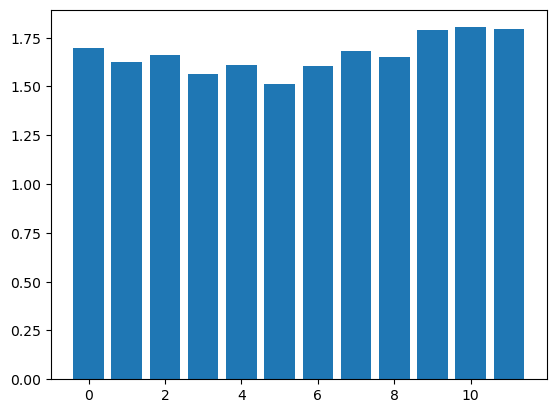

In [145]:
metric_dict = dict(metric_dict)
metric_dict['RMSE'] = [i/60 for i in metric_dict['RMSE']]
metric_dict['MAE'] = [i/60 for i in metric_dict['MAE']]
times = [i for i in range(12)]
plt.bar(times,metric_dict['RMSE'])
#plt.bar(times, metric_dict['MAE'])
#plt.xticks(times)
plt.show()

In [146]:
print(np.mean(metric_dict['RMSE']))

1.6662072006966862


In [147]:
metrics = evaluate_model(y_test_true, y_test_pred)

MSE : 10022.939682986618
RMSE : 100.1146327116402
R-squared : 0.2482704277276103
MAE : 48.679490798711015


# Predicting ETA

In [111]:
def get_dwelltime(seg_indices, y_now):
    dwelltime = 0
    for seg_index in seg_indices:
        #print(len(y_now), seg_index)
        if y_now[int(seg_index)]>0:
            dwelltime += y_now[int(seg_index)]
    if len(seg_indices) == 0:
        return 0
    return dwelltime

In [112]:
def dist_between_stops(segment_list):
    if len(segment_list)==0:
        return 0
    total_dist = 0
    for seg in segment_list:
        total_dist += new_segment_dict[seg]['length']
    return total_dist

## Get Bus stop segments

In [113]:
surat_bus_stop_df = pd.read_json("./surat_bus_stop.json")

In [114]:
def get_route_segment_dict(route_id):
    route_segment_dict = {}
    for seg in route_to_segments[route_id]:
        if seg == -1:
            continue
        route_segment_dict[seg] = new_segment_dict[seg]
    return route_segment_dict

In [115]:
def get_stop_segments(route_id, stops, route_segment_dict):
    stop_segments = []
    coord_seg_dict = {}
    for coord in tqdm(stops):
        seg = geo_to_segment(coord[1], coord[0], h3_to_seg, route_segment_dict)
        if seg == -1:
            continue
        if seg is not None and seg in route_to_segments[route_id]:
            stop_segments.append(seg)
            coord_seg_dict[tuple(coord)] = seg
    return stop_segments
    return stop_segments, coord_seg_dict

In [116]:
def get_bus_stop_segments(route_id):
    stop_coordinates = surat_bus_stop_df[surat_bus_stop_df['route_id']==route_id]['location'].tolist()[1]['coordinates']
    route_segment_dict = get_route_segment_dict(route_id)
    return get_stop_segments(route_id, stop_coordinates, route_segment_dict)

In [117]:
selected_route_id = '903D'

In [120]:
stops = get_bus_stop_segments(selected_route_id)

100%|██████████| 21/21 [00:00<00:00, 4858.80it/s]


In [121]:
selected_time_slot = 0
y_true_now = y_test_true.T[selected_time_slot]
y_pred_now = y_test_pred.T[selected_time_slot]

In [122]:
def stop_time(route_id):
    stops_time_pred_dict = {}
    stops_time_dict = {}
    total_true_time = 0
    total_pred_time = 0
    curr_time_slot_true = 0
    curr_time_slot_pred = 0
    stop_segments = get_bus_stop_segments(route_id)
    for seg_idx in range(len(stop_segments[1:])):
        y_true_now = y_test_true.T[curr_time_slot_true%12]
        y_pred_now = y_test_pred.T[curr_time_slot_pred%12]
        index1 = route_to_segments[route_id].index(stop_segments[seg_idx-1])
        index2 = route_to_segments[route_id].index(stop_segments[seg_idx])
        seg_list = route_to_segments[route_id][index1:index2+1]
        try:
            curr_dwelltime_pred = get_dwelltime(seg_list, y_pred_now)/60
            curr_dwelltime = get_dwelltime(seg_list, y_true_now)/60
        except:
            curr_dwelltime_pred = 0
            curr_dwelltime = 0
            
        total_true_time += curr_dwelltime
        total_pred_time += curr_dwelltime_pred
        
        # (FROM, TO) -> Time taken
        stops_time_pred_dict[(stop_segments[seg_idx-1], stop_segments[seg_idx])] = curr_dwelltime_pred
        stops_time_dict[(stop_segments[seg_idx-1], stop_segments[seg_idx])] = curr_dwelltime
    
    if total_pred_time > 60:
        total_pred_time -= 60
        curr_time_slot_pred += 1
    if total_true_time > 60:
        total_true_time -= 60
        curr_time_slot_true += 1
    
    return list(stops_time_pred_dict.values()), list(stops_time_dict.values())

In [123]:
stops_eta_pred, stops_eta_true = stop_time(selected_route_id)

100%|██████████| 21/21 [00:00<00:00, 4976.57it/s]


In [124]:
stops_eta_pred

[0.0,
 2.4401248772939046,
 8.225677299499512,
 2.534887186686198,
 6.968540032704671,
 14.893380935986837,
 7.152960141499837,
 3.522942860921224,
 2.2913321177164714,
 5.32004534403483,
 3.647076416015625,
 3.8205556233723956,
 4.731411298116048,
 7.947419738769531,
 4.702302130063375,
 4.311279074350993]

In [125]:
stops_eta_true

[0.0,
 1.7335068372056444,
 4.206915149650913,
 2.2467704663829324,
 4.643222010502994,
 19.502916963150053,
 5.532154388867725,
 3.1201199615681703,
 2.0802955618453045,
 4.593231268248739,
 3.054763995332496,
 3.664367971173401,
 3.3159458654747396,
 4.206403969631383,
 4.308907589912194,
 4.431660824200654]

In [126]:
np.median(stops_eta_true)

3.9353859704023924

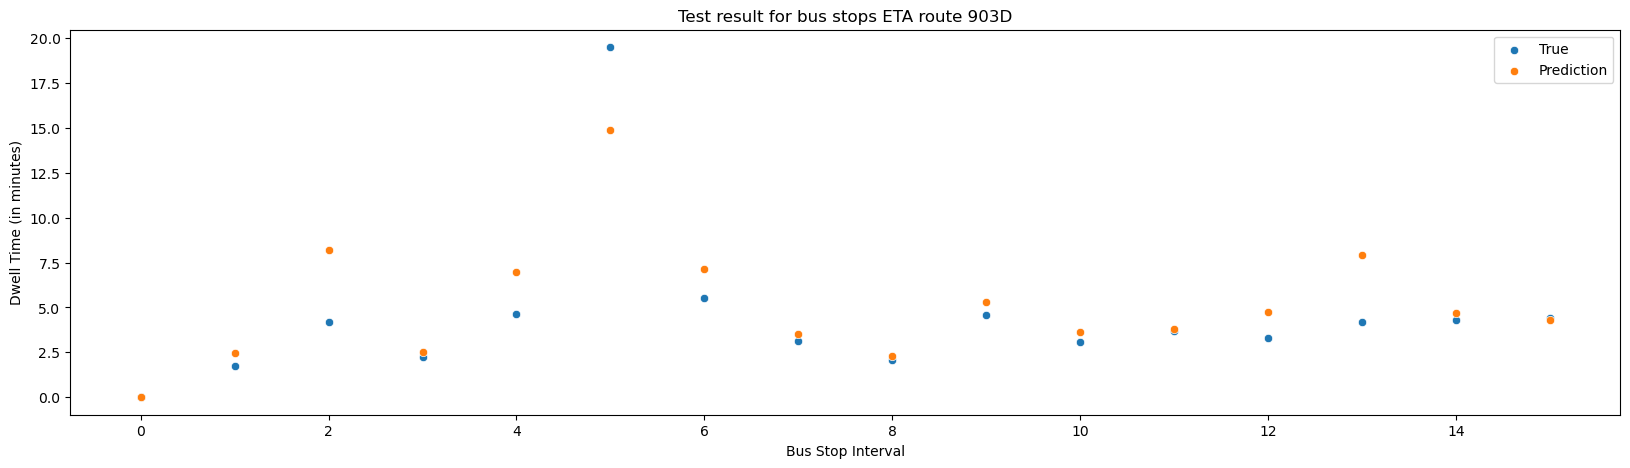

In [127]:
x = [i for i in range(len(stops_eta_true))]
plt.figure(figsize=(20, 5))
sns.scatterplot(y=stops_eta_true, x=x, label='True')
sns.scatterplot(y=stops_eta_pred, x=x, label='Prediction')
plt.title(f'Test result for bus stops ETA route {selected_route_id}')
plt.xlabel('Bus Stop Interval')
plt.ylabel('Dwell Time (in minutes)')
plt.plot()
plt.show()

In [128]:
stops_eta_vals = []
stops_eta_pred_vals = []
curr_val_true = 0
curr_val_pred = 0
for index in range(len(stops_eta_pred)):
    stops_eta_vals.append(curr_val_true+stops_eta_true[index])
    curr_val_true += stops_eta_true[index]
    stops_eta_pred_vals.append(curr_val_pred+stops_eta_pred[index])
    curr_val_pred += stops_eta_pred[index]

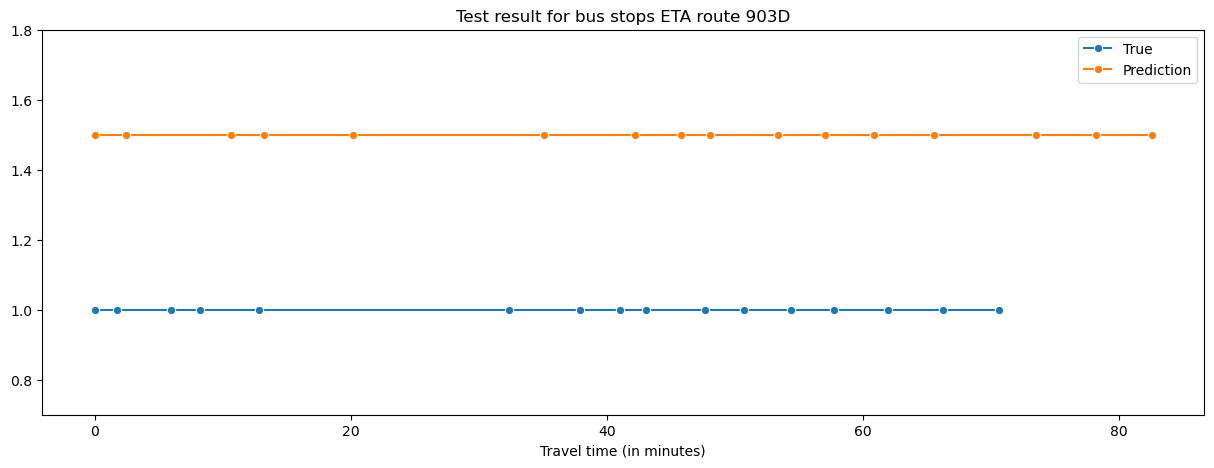

Absolute error in prediction = 11.868752253884125


In [129]:
y1 = [1 for _ in range(len(stops_eta_true))]
y2 = [1.5 for _ in range(len(stops_eta_pred))]
plt.figure(figsize=(15, 5))
plt.ylim(0.7, 1.8)
sns.lineplot(y=y1, x=stops_eta_vals, label='True', marker='o')
sns.lineplot(y=y2, x=stops_eta_pred_vals, label='Prediction', marker='o')
plt.title(f'Test result for bus stops ETA route {selected_route_id}')
plt.xlabel('Travel time (in minutes)')
plt.plot()
plt.show()
print(f'Absolute error in prediction = {abs(stops_eta_vals[-1] - stops_eta_pred_vals[-1])}')

# Stop-wise prediction on Test Data

In [130]:
final_routes = ['706D',
 '105U',
 '01U',
 '22D',
 '903U',
 '112U',
 '305U',
 '12D',
 '403D',
 '402U',
 '903D',
 '658U',
 '136U',
 '205GU',
 '204D',
 '17AD',
 '213U',
 '716U',
 '17AU',
 '216BD',
 '706U',
 '206D',
 '410U',
 '20D',
 '504D',
 '118U',
 '402D',
 '11D',
 '207ED',
 '12U',
 '17AEU',
 '17AED',
 '504U',
 '205GD',
 '213D',
 '206U',
 '207EU',
 '403U',
 '658D',
 '716D',
 '254U',
 '254D',
 '16U',
 '136D',
 '305D',
 '118D',
 '14D',
 '02U',
 '302D',
 '302U',
 '105D']